# **Import Libraries**

In [24]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, log_loss, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import math


import xgboost as xgb

# For saving and loading models (used later in the dashboard)
import pickle


# **Load Data**

In [4]:
# Load the dataset
from google.colab import files
uploaded = files.upload('/Users/jasleenkaur/Downloads/default of credit card clients.xls')

# 3. Get the filename from the uploaded dictionary
file_name = list(uploaded.keys())[0]

# 4. Now read the Excel file properly
df = pd.read_excel(file_name)

Saving default of credit card clients.xls to /Users/jasleenkaur/Downloads/default of credit card clients.xls/default of credit card clients.xls


# **Display first few rows and basic information**

In [5]:
print("\nData Shape:", df.shape)
print("\nColumns in the dataset:", df.columns.tolist())
print("\nFirst few rows of the data:")
print(df.head())


Data Shape: (30000, 25)

Columns in the dataset: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']

First few rows of the data:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ... 

# **Data Preprocessing and Feature Engineering**

In [6]:
# Cell 3: Data Preprocessing and Feature Engineering

# Drop the 'ID' column as it is not useful for modeling
if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)

df['credit_utilization'] = df['BILL_AMT1'] / df['LIMIT_BAL']
df['payment_ratio'] = df['PAY_AMT1'] / df['BILL_AMT1'].replace(0, np.nan)
df['payment_ratio'] = df['payment_ratio'].fillna(0)
df['average_bill'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3']].mean(axis=1)


# Fill any NaNs resulting from division by zero with 0
df.fillna(0, inplace=True)

df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,credit_utilization,payment_ratio,average_bill
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,689,0,0,0,0,1,0.195650,0.000000,2568.000000
1,120000,2,2,2,26,-1,2,0,0,0,...,0,1000,1000,1000,0,2000,1,0.022350,0.000000,2363.000000
2,90000,2,2,2,34,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0.324878,0.051917,18941.666667
3,50000,2,2,1,37,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,0.939800,0.042562,48171.333333
4,50000,1,2,1,57,-1,0,-1,0,0,...,2000,36681,10000,9000,689,679,0,0.172340,0.232099,16707.333333


# **Data Visualization (EDA)**

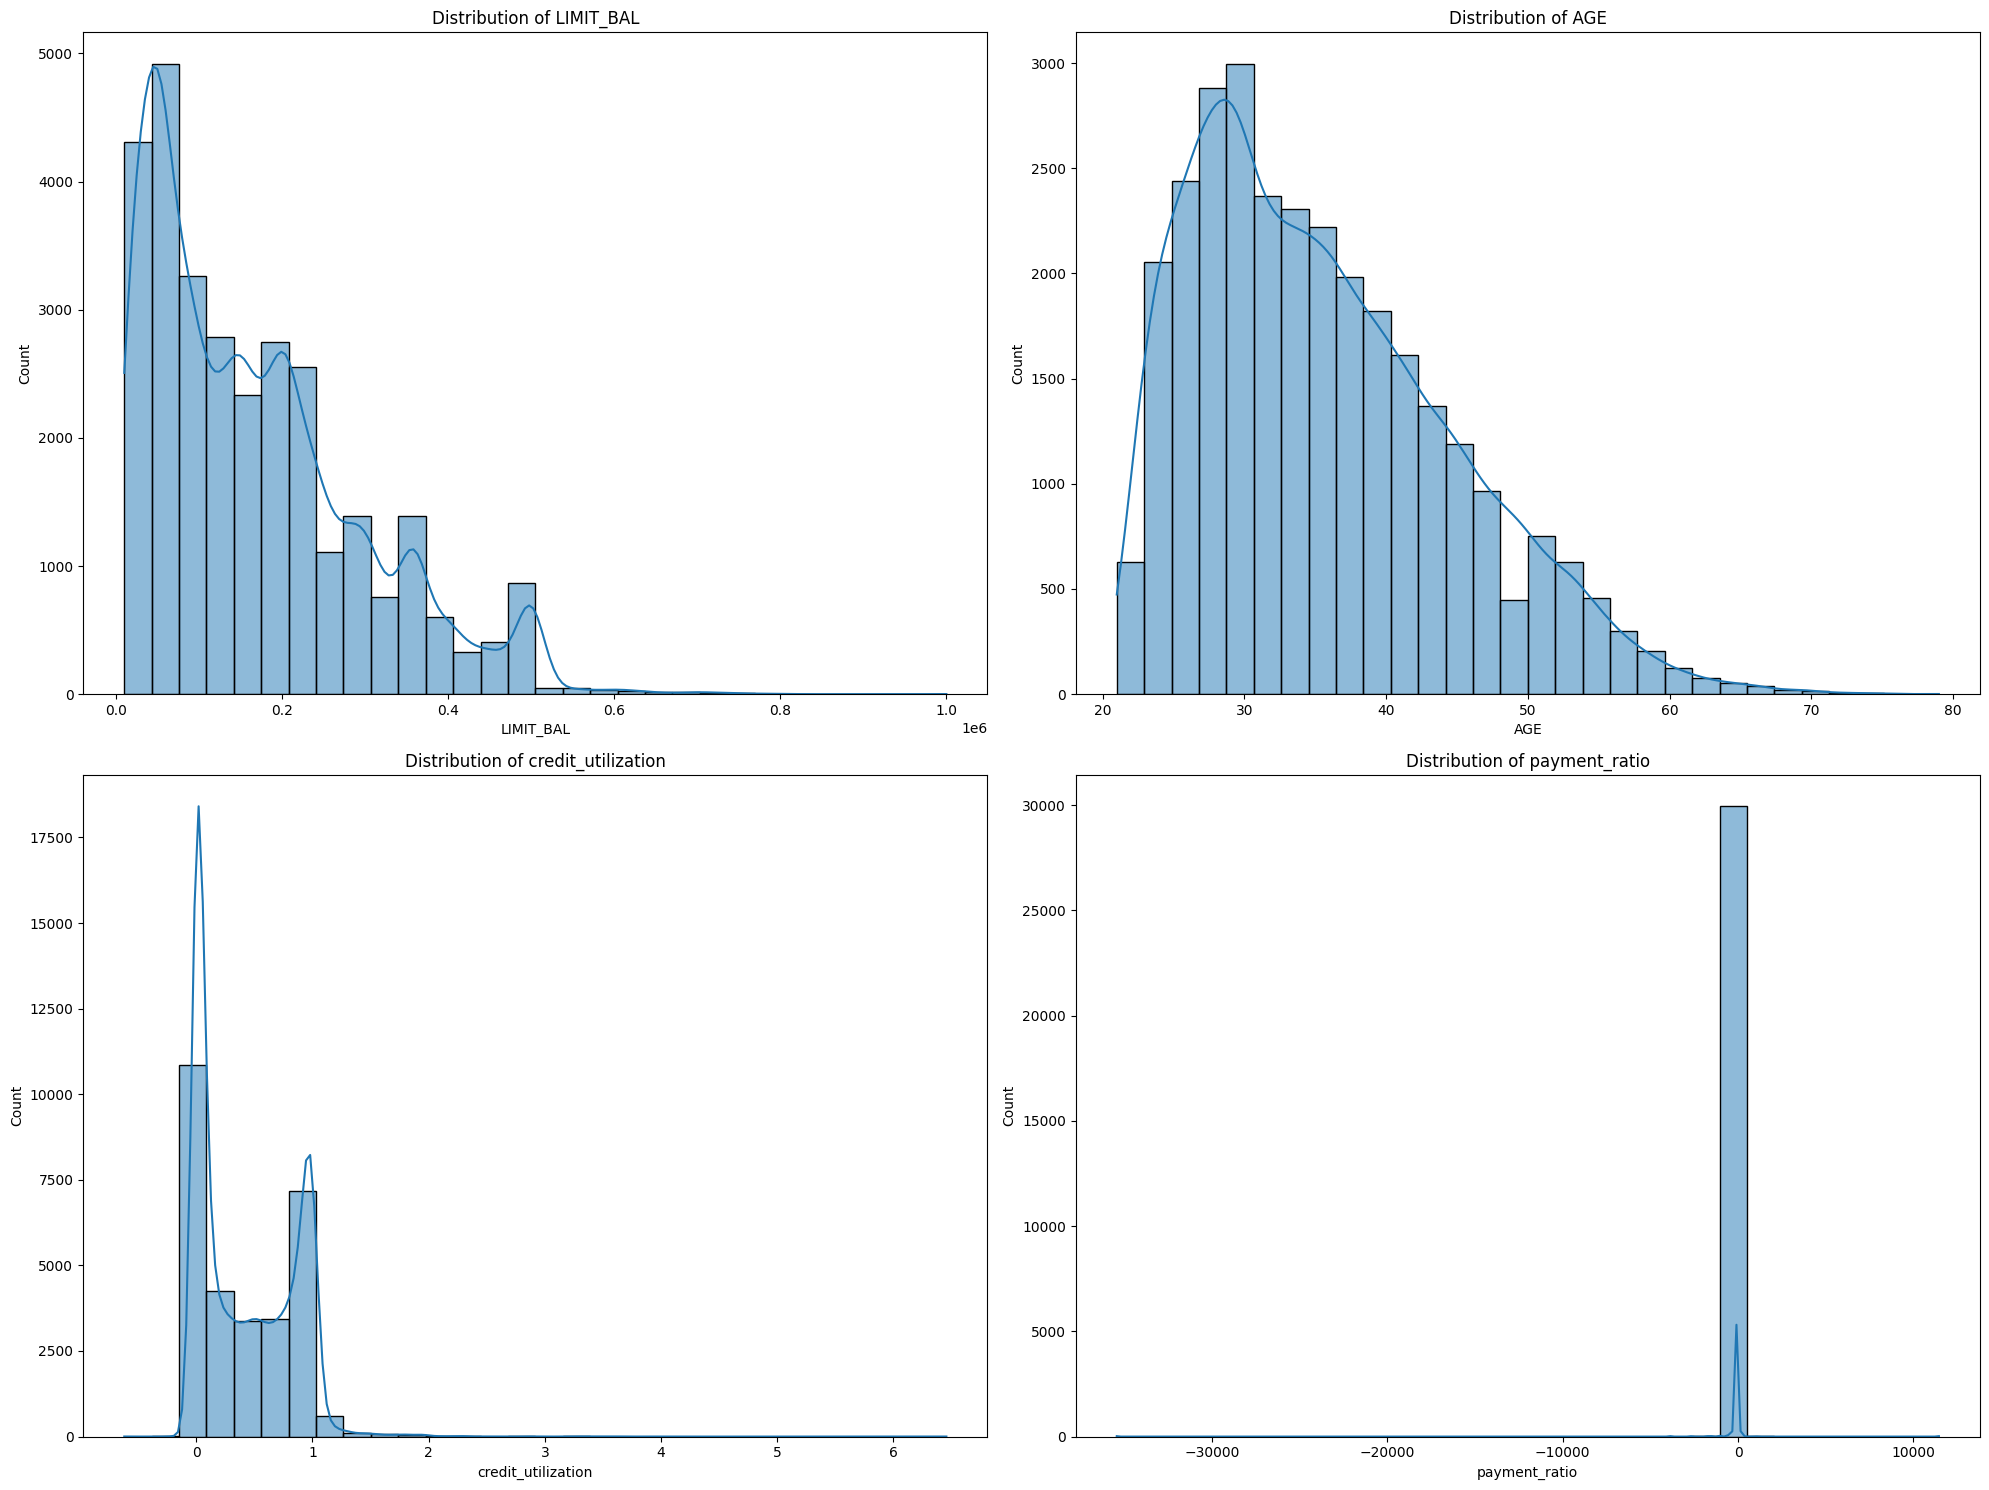

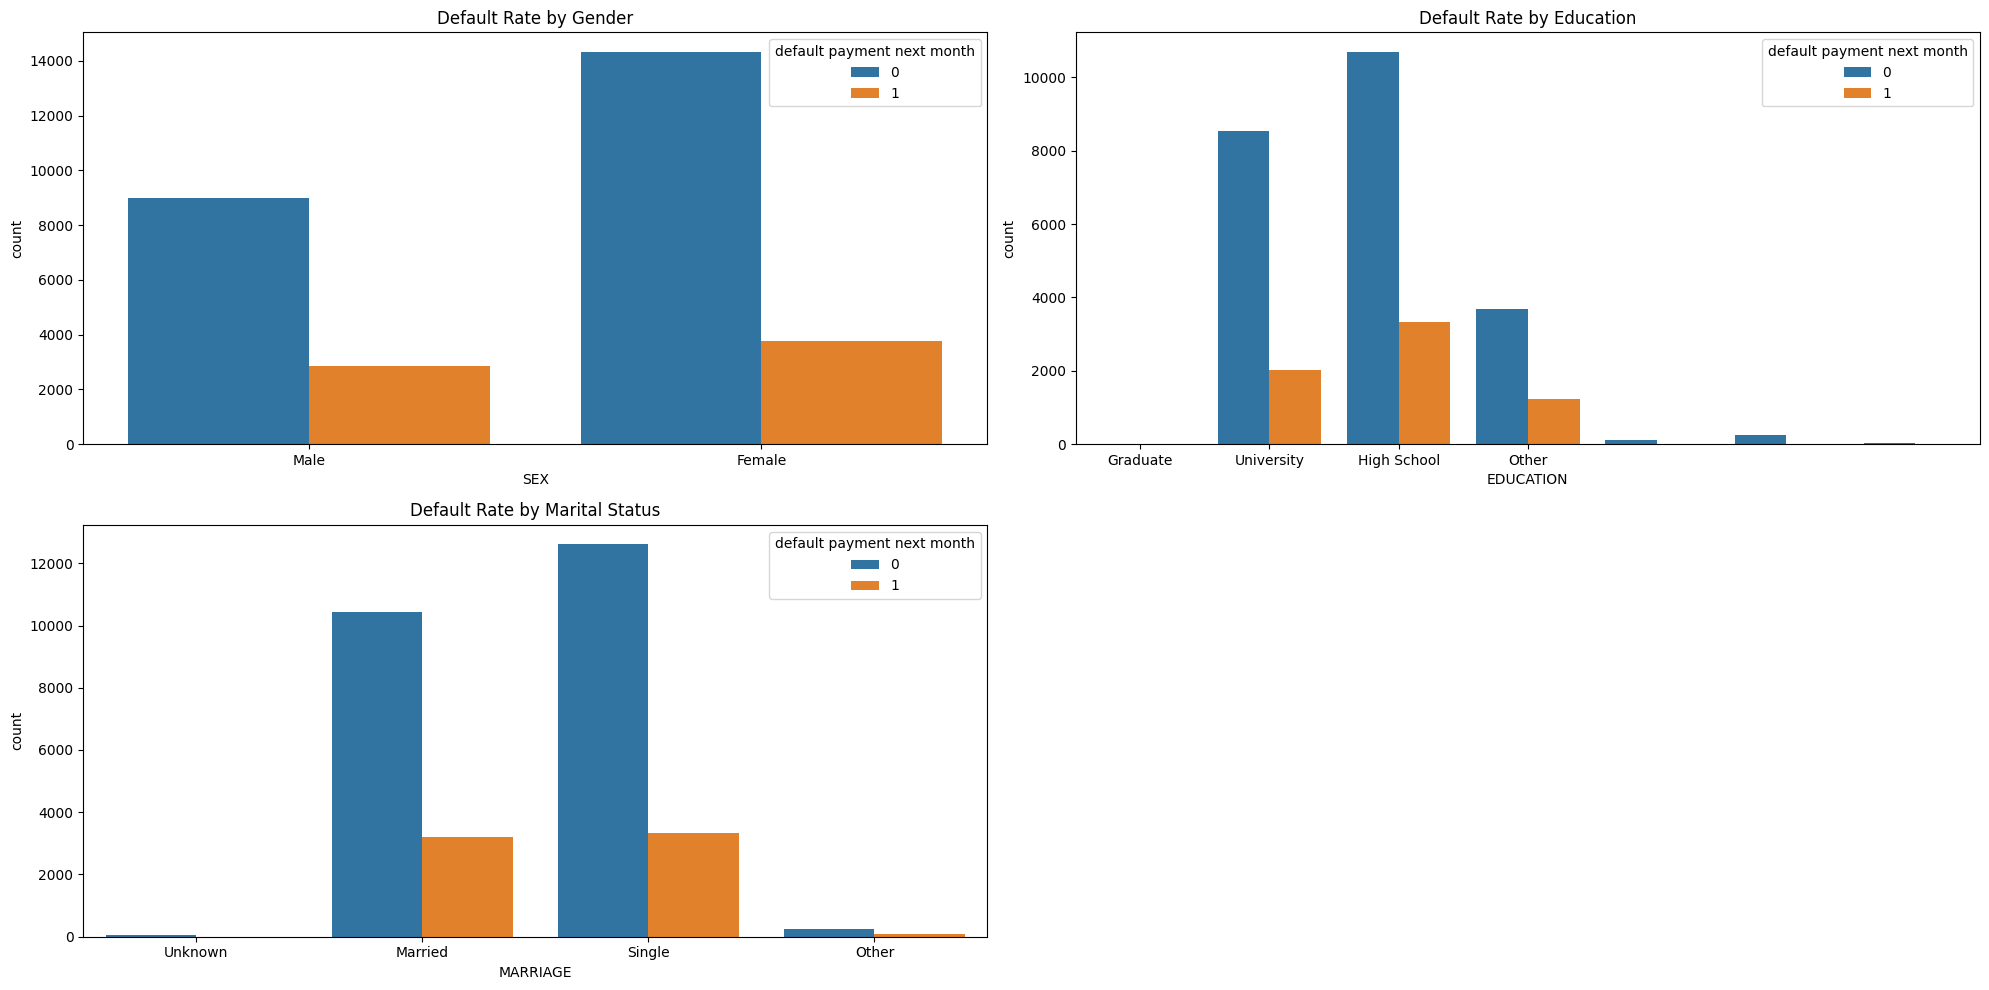

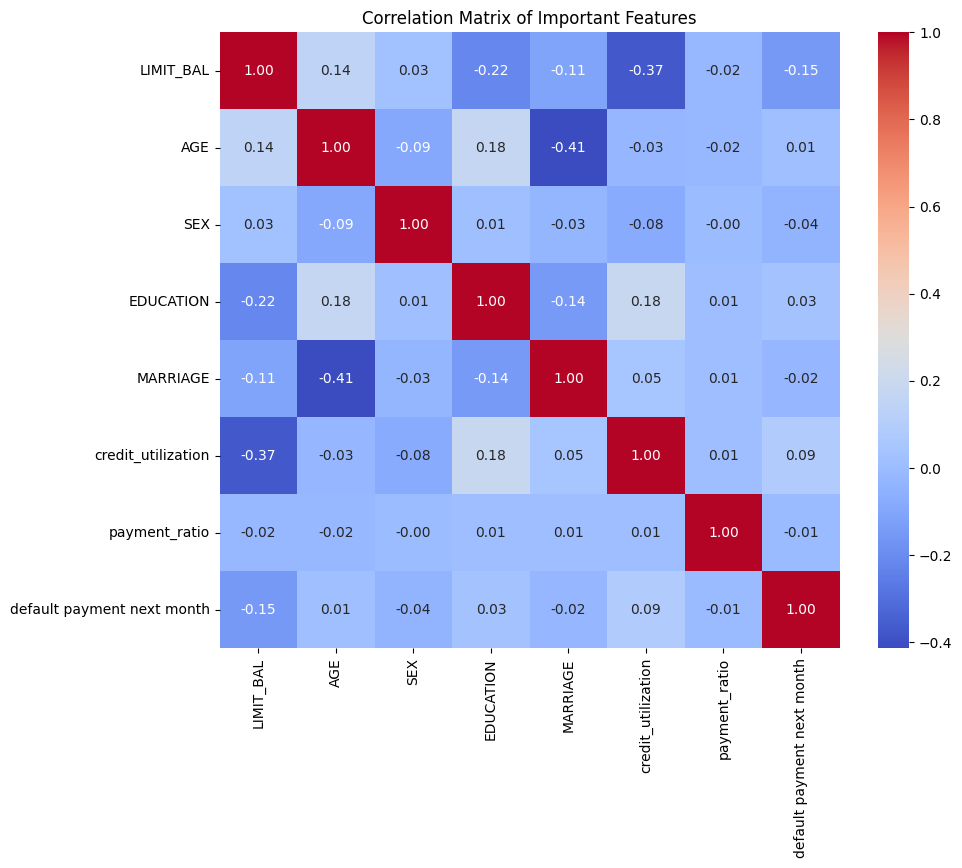

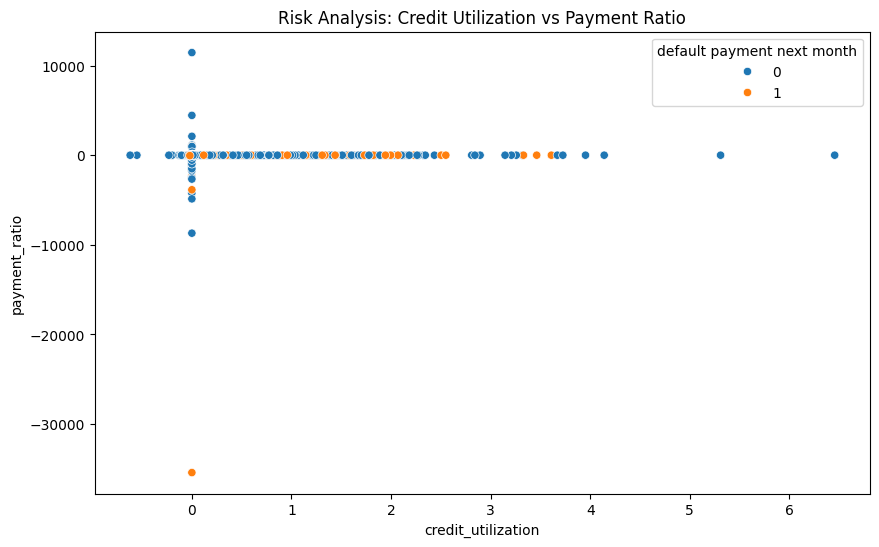

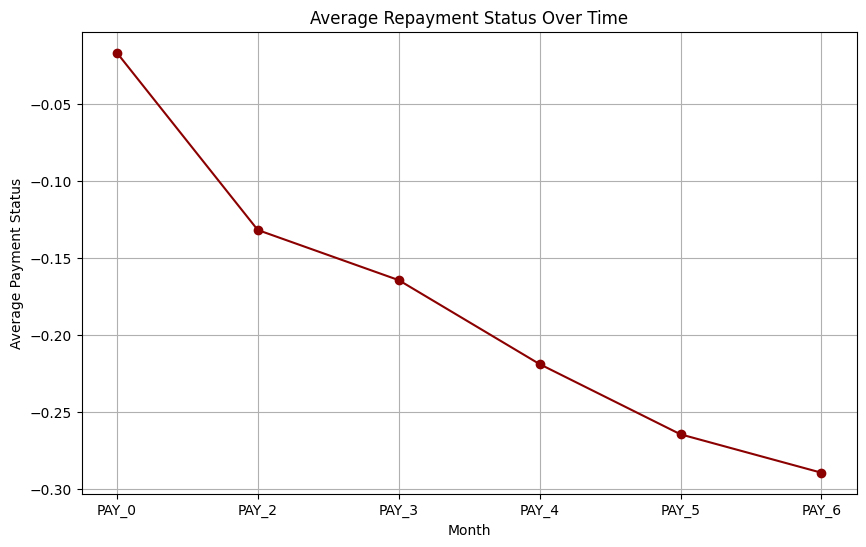

In [7]:
# Remove duplicates from the dataset
df = df.drop_duplicates()

# Define important columns for EDA
important_cols = ['LIMIT_BAL', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE',
                  'credit_utilization', 'payment_ratio', 'default payment next month']

# Set figure size
plt.figure(figsize=(20, 15))

# 1. Distribution of Numerical Features
numerical_cols = ['LIMIT_BAL', 'AGE', 'credit_utilization', 'payment_ratio']
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2. Categorical Analysis with Default Rate
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
sns.countplot(data=df, x='SEX', hue='default payment next month')
plt.title('Default Rate by Gender')
plt.xticks([0, 1], ['Male', 'Female'])

plt.subplot(2, 2, 2)
sns.countplot(data=df, x='EDUCATION', hue='default payment next month')
plt.title('Default Rate by Education')
plt.xticks([0, 1, 2, 3], ['Graduate', 'University', 'High School', 'Other'])

plt.subplot(2, 2, 3)
sns.countplot(data=df, x='MARRIAGE', hue='default payment next month')
plt.title('Default Rate by Marital Status')
plt.xticks([0, 1, 2, 3], ['Unknown', 'Married', 'Single', 'Other'])

plt.tight_layout()
plt.show()

# 3. Correlation Heatmap of Important Features
plt.figure(figsize=(10, 8))
sns.heatmap(df[important_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Important Features')
plt.show()

# 4. Credit Utilization vs Payment Ratio (Risk Analysis)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='credit_utilization', y='payment_ratio', hue='default payment next month')
plt.title('Risk Analysis: Credit Utilization vs Payment Ratio')
plt.show()

# 5. PAYMENT STATUS TREND OVER TIME
plt.figure(figsize=(10, 6))
pay_columns = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
df[pay_columns].mean().plot(marker='o', color="darkred")
plt.xticks(range(len(pay_columns)), pay_columns)
plt.title("Average Repayment Status Over Time")
plt.xlabel("Month")
plt.ylabel("Average Payment Status")
plt.grid()
plt.show()

# **Prepare data for Modeling**

In [8]:
# Cell 5: Prepare Data for Modeling

# Define X (features) and y (target)
# Assuming the target column is named 'default payment next month'
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# Split the data into training and test sets (stratify for imbalanced classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **Deep Learning Model Building**

In [9]:
# New Cell: Build the Advanced Deep Learning Model
def build_deep_model(input_dim):
    inputs = Input(shape=(input_dim,))

    # First block: Dense + BatchNormalization + Dropout
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Residual branch: create a parallel dense block
    res = Dense(128, activation='relu')(x)
    res = BatchNormalization()(res)
    res = Dropout(0.3)(res)

    # Merge residual branch with main branch
    x = Add()([x, res])
    x = Activation('relu')(x)

    # Additional block
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate and display the model summary
deep_model = build_deep_model(X_train.shape[1])
deep_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      3,456 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,569 (115.50 KB)

 Trainable params: 28,929 (113.00 KB)

 Non-trainable params: 640 (2.50 KB)

# **Train Deep Learning Model**

In [10]:
# New Cell: Set Up Callbacks and Train the Deep Learning Model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history_deep = deep_model.fit(X_train, y_train,
                              validation_split=0.2,
                              epochs=100,
                              batch_size=64,
                              callbacks=[early_stop, reduce_lr])


Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.6385 - loss: 0.6875 - val_accuracy: 0.7673 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7624 - loss: 0.5446 - val_accuracy: 0.7687 - val_loss: 0.5229 - learning_rate: 0.0010
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7724 - loss: 0.5201 - val_accuracy: 0.7683 - val_loss: 0.5185 - learning_rate: 0.0010
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7719 - loss: 0.5171 - val_accuracy: 0.7679 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7774 - loss: 0.5065 - val_accuracy: 0.7687 - val_loss: 0.5693 - learning_rate: 0.0010
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7716 - loss: 0.5125 - val_accuracy: 0.7683 - val_loss: 0.7691 - learning_rate: 0.0010
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7818 - loss:

# **Evaluate Deep Learning Model**

In [11]:
# New Cell: Evaluate the Deep Learning Model
loss_deep, accuracy_deep = deep_model.evaluate(X_test, y_test)
print("Deep Learning Model Test Loss:", loss_deep)
print("Deep Learning Model Test Accuracy:", accuracy_deep)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7784 - loss: 0.5095
Deep Learning Model Test Loss: 0.5053216218948364
Deep Learning Model Test Accuracy: 0.779075562953949


# **Model Building**

In [15]:
# Cell 6: Model Building

# RandomForest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# **Building RandomForest Classification Pipeline**

In [16]:

# Assume X_train and X_test are pandas DataFrames with consistent column names

# Create a pipeline that scales the data and fits a RandomForest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the training data (which is a DataFrame)
rf_pipeline.fit(X_train, y_train)

# Predict using the pipeline on the test DataFrame
y_pred = rf_pipeline.predict(X_test)


# **Model Evaluation**

In [17]:
# Cell 7: Model Evaluation

# --- RandomForest Evaluation ---
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
logloss_rf = log_loss(y_test, y_prob_rf)

print("RandomForest Performance Metrics:")
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print(f"Precision: {precision_rf * 100:.2f}%")
print(f"Recall: {recall_rf * 100:.2f}%")
print(f"F1 Score: {f1_rf * 100:.2f}%")
print(f"ROC-AUC: {roc_auc_rf:.2f}")
print(f"Log Loss: {logloss_rf:.2f}")

# --- XGBoost Evaluation ---
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
logloss_xgb = log_loss(y_test, y_prob_xgb)

print("\nXGBoost Performance Metrics:")
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"Precision: {precision_xgb * 100:.2f}%")
print(f"Recall: {recall_xgb * 100:.2f}%")
print(f"F1 Score: {f1_xgb * 100:.2f}%")
print(f"ROC-AUC: {roc_auc_xgb:.2f}")
print(f"Log Loss: {logloss_xgb:.2f}")

RandomForest Performance Metrics:
Accuracy: 81.01%
Precision: 62.30%
Recall: 35.90%
F1 Score: 45.55%
ROC-AUC: 0.76
Log Loss: 0.45

XGBoost Performance Metrics:
Accuracy: 81.43%
Precision: 64.30%
Recall: 36.12%
F1 Score: 46.26%
ROC-AUC: 0.76
Log Loss: 0.46


# **Future Expense Prediction**

In [18]:
def predict_future_expenses(user_data, months_ahead=3):
    """Predict future expenses based on historical data"""
    features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']
    X = user_data[features]

    future_expenses = []
    current_amount = X['BILL_AMT1']

    for i in range(months_ahead):
        # Calculate average change in expenses
        avg_change = (X['BILL_AMT1'] - X['BILL_AMT3']) / 3
        predicted_amount = current_amount + avg_change
        future_expenses.append(predicted_amount)
        current_amount = predicted_amount

    return future_expenses

# Example user data
example_user = pd.DataFrame({
    'BILL_AMT1': [20000],
    'BILL_AMT2': [19000],
    'BILL_AMT3': [18000],
    'PAY_AMT1': [2000],
    'PAY_AMT2': [1900],
    'PAY_AMT3': [1800]
})

# Predict future expenses
future_expenses = predict_future_expenses(example_user)
print("Predicted Expenses for Next 3 Months:")
for i, amount in enumerate(future_expenses, 1):
    print(f"Month {i}: ${float(amount):,.2f}")

Predicted Expenses for Next 3 Months:
Month 1: $20,666.67
Month 2: $21,333.33
Month 3: $22,000.00


<ipython-input-18-f0402cb2a42c>:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Month {i}: ${float(amount):,.2f}")


# **Financial Advice Generation**

In [19]:
def generate_financial_advice(user_data):
    """Generate personalized financial advice"""
    advice = []

    # Credit utilization advice
    if user_data['credit_utilization'].iloc[0] > 0.3:
        advice.append("⚠️ Your credit utilization is high. Consider reducing credit card spending.")

    # Payment behavior advice
    if user_data['payment_ratio'].iloc[0] < 0.1:
        advice.append("⚠️ Your payment to bill ratio is low. Try to increase monthly payments.")

    # Spending trend advice
    bills = user_data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].values[0]
    if bills[0] > bills[1] > bills[2]:
        advice.append("📈 Your spending is increasing. Consider creating a budget.")

    return advice

# Example user data
example_user_full = pd.DataFrame({
    'LIMIT_BAL': [50000],
    'BILL_AMT1': [20000],
    'BILL_AMT2': [19000],
    'BILL_AMT3': [18000],
    'credit_utilization': [0.4],
    'payment_ratio': [0.1]
})

# Generate advice
advice = generate_financial_advice(example_user_full)
print("Personalized Financial Advice:")
for item in advice:
    print(item)

Personalized Financial Advice:
⚠️ Your credit utilization is high. Consider reducing credit card spending.
📈 Your spending is increasing. Consider creating a budget.


# **Financial Advisory**

In [20]:
# Cell 8: Prediction and Financial Advisory Function

def financial_advisory(risk_score):
    """
    Generate financial advisory recommendation based on predicted risk.
    :param risk_score: Predicted probability of default.
    :return: Advisory recommendation string.
    """
    if risk_score > 0.7:
        return "High risk detected. Consider reducing unnecessary expenses and consult a financial advisor."
    elif risk_score > 0.4:
        return "Moderate risk. Monitor your spending closely and consider setting up a strict budget plan."
    else:
        return "Low risk. Continue maintaining healthy financial habits."

# Example usage for a sample test instance:
sample_idx = 0
sample_prob = xgb_model.predict_proba(X_test_scaled[sample_idx].reshape(1, -1))[0, 1]
print(f"Predicted default probability: {sample_prob:.2f}")
print("Advisory Recommendation:", financial_advisory(sample_prob))


Predicted default probability: 0.14
Advisory Recommendation: Low risk. Continue maintaining healthy financial habits.


# **Savings Plan Generation**

In [21]:
def create_savings_plan(user_data):
    """Generate a personalized savings plan"""
    monthly_income = user_data['LIMIT_BAL'].iloc[0] * 0.3  # Estimated income
    monthly_expenses = user_data['BILL_AMT1'].iloc[0]

    savings_plan = {
        'recommended_monthly_savings': max(0, monthly_income - monthly_expenses),
        'emergency_fund_target': monthly_expenses * 6,
        'debt_payment_suggestion': min(monthly_expenses * 0.2, user_data['BILL_AMT1'].iloc[0]),
        'discretionary_spending_limit': monthly_income * 0.3
    }

    return savings_plan

# Generate savings plan
savings_plan = create_savings_plan(example_user_full)
print("Personalized Savings Plan:")
for key, value in savings_plan.items():
    print(f"{key.replace('_', ' ').title()}: ${value:,.2f}")

Personalized Savings Plan:
Recommended Monthly Savings: $0.00
Emergency Fund Target: $120,000.00
Debt Payment Suggestion: $4,000.00
Discretionary Spending Limit: $4,500.00


# **Main Logic**

In [22]:
###############################################################################
# 1) DEFINE THE EXACT COLUMNS YOUR SCALER/MODEL EXPECT AT TRAINING TIME
###############################################################################
TRAINING_COLS = [
    "LIMIT_BAL",
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "AGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
    "credit_utilization",
    "payment_ratio",
    "average_bill"
]

###############################################################################
# 3) USER INPUT FUNCTION (WITH PLACEHOLDERS FOR MISSING COLUMNS)
###############################################################################
def get_user_input():
    """Prompt user for partial data, then add placeholder columns for the rest."""
    try:
        print("Enter your financial information:")
        # Minimal user input
        user_data = {
            'LIMIT_BAL': float(input("Credit limit: ")),
            'BILL_AMT1': float(input("Current month bill: ")),
            'BILL_AMT2': float(input("Last month bill: ")),
            'BILL_AMT3': float(input("Two months ago bill: ")),
            'PAY_AMT1': float(input("Current month payment: ")),
            'PAY_AMT2': float(input("Last month payment: "))
        }

        # ---------------------------------------------------------------------
        # 3a) ADD PLACEHOLDERS FOR REQUIRED COLUMNS NOT COLLECTED FROM USER
        # ---------------------------------------------------------------------
        # Adjust default values as needed
        user_data['SEX'] = 1
        user_data['EDUCATION'] = 2
        user_data['MARRIAGE'] = 1
        user_data['AGE'] = 30

        user_data['PAY_0'] = 0
        user_data['PAY_2'] = 0
        user_data['PAY_3'] = 0
        user_data['PAY_4'] = 0
        user_data['PAY_5'] = 0
        user_data['PAY_6'] = 0

        user_data['BILL_AMT4'] = 0
        user_data['BILL_AMT5'] = 0
        user_data['BILL_AMT6'] = 0

        user_data['PAY_AMT3'] = 0
        user_data['PAY_AMT4'] = 0
        user_data['PAY_AMT5'] = 0
        user_data['PAY_AMT6'] = 0

        # ---------------------------------------------------------------------
        # 3b) ENGINEERED FEATURES
        # ---------------------------------------------------------------------
        # credit_utilization
        if user_data['LIMIT_BAL'] != 0:
            credit_util = user_data['BILL_AMT1'] / user_data['LIMIT_BAL']
        else:
            credit_util = 0
        user_data['credit_utilization'] = np.clip(credit_util, 0, 10)

        # payment_ratio
        if user_data['BILL_AMT1'] != 0:
            payment_ratio = user_data['PAY_AMT1'] / user_data['BILL_AMT1']
        else:
            payment_ratio = 0
        user_data['payment_ratio'] = np.clip(payment_ratio, 0, 5)

        # average_bill
        user_data['average_bill'] = np.mean([
            user_data['BILL_AMT1'],
            user_data['BILL_AMT2'],
            user_data['BILL_AMT3']
        ])

        # ---------------------------------------------------------------------
        # 3c) BUILD A DATAFRAME WITH EXACT TRAINING COLS
        # ---------------------------------------------------------------------
        df_user = pd.DataFrame([user_data])
        # Reindex to match training columns, fill missing with 0
        df_user = df_user.reindex(columns=TRAINING_COLS, fill_value=0)
        return df_user

    except ValueError:
        print("Please enter valid numerical values.")
        return None

###############################################################################
# 4) FINANCIAL ADVICE FUNCTIONS
###############################################################################
def generate_financial_advice(user_data):
    """Generate personalized financial advice based on user_data row."""
    advice = []

    util = user_data['credit_utilization'].iloc[0]
    if util > 0.7:
        advice.append("🔴 Very high credit utilization. Urgently reduce credit card spending.")
    elif util > 0.3:
        advice.append("🟡 Credit utilization is above recommended levels. Consider reducing credit card use.")
    else:
        advice.append("✅ Good job! Your credit utilization is within recommended levels.")

    pay_ratio = user_data['payment_ratio'].iloc[0]
    if pay_ratio >= 1:
        advice.append("✅ Excellent! You're paying more than your monthly bill.")
    elif pay_ratio < 0.1:
        advice.append("🔴 Very low payment to bill ratio. Increase monthly payments to avoid debt accumulation.")
    else:
        advice.append("🟡 Consider increasing your monthly payments to reduce interest charges.")

    bills = [
        user_data['BILL_AMT1'].iloc[0],
        user_data['BILL_AMT2'].iloc[0],
        user_data['BILL_AMT3'].iloc[0]
    ]
    if bills[0] > bills[1] > bills[2]:
        advice.append("📈 Your spending has been increasing. Consider creating a budget.")
    elif bills[0] < bills[1] < bills[2]:
        advice.append("📉 Great! Your spending trend is decreasing.")

    return advice

def create_savings_plan(user_data):
    """Generate a personalized savings plan (example logic)."""
    monthly_income = user_data['LIMIT_BAL'].iloc[0] * 0.3  # hypothetical
    monthly_expenses = user_data['BILL_AMT1'].iloc[0]

    plan = {
        'recommended_monthly_savings': max(0, monthly_income - monthly_expenses),
        'emergency_fund_target': monthly_expenses * 6,
        'debt_payment_suggestion': min(monthly_expenses * 0.2, monthly_expenses),
        'discretionary_spending_limit': monthly_income * 0.3
    }
    return plan

###############################################################################
# 5) MAIN LOGIC: GET USER DATA, PRINT ADVICE, PREDICT RISK
###############################################################################
user_data = get_user_input()
if user_data is not None:
    # --- Personalized Advice ---
    print("\n📋 Personalized Financial Advice:")
    advice_list = generate_financial_advice(user_data)
    for item in advice_list:
        print(item)

    # --- Savings Plan ---
    print("\n💰 Personalized Savings Plan:")
    savings_plan = create_savings_plan(user_data)
    for key, value in savings_plan.items():
        print(f"{key.replace('_', ' ').title()}: ${value:,.2f}")

    # --- Risk Assessment ---
    # 'scaler' and 'risk_model' must be loaded from your training phase
    risk_model = rf_model
    features_scaled = scaler.transform(user_data)
    risk_probability = risk_model.predict_proba(features_scaled)[0][1]

    print(f"\n🎯 Risk Assessment:")
    if risk_probability < 0.3:
        print(f"Low risk profile (Risk Score: {risk_probability:.1%})")
    elif risk_probability < 0.6:
        print(f"Medium risk profile (Risk Score: {risk_probability:.1%})")
    else:
        print(f"High risk profile (Risk Score: {risk_probability:.1%})")


Enter your financial information:
Credit limit: 1000
Current month bill: 500
Last month bill: 40
Two months ago bill: 30
Current month payment: 20
Last month payment: 30

📋 Personalized Financial Advice:
🟡 Credit utilization is above recommended levels. Consider reducing credit card use.
🔴 Very low payment to bill ratio. Increase monthly payments to avoid debt accumulation.
📈 Your spending has been increasing. Consider creating a budget.

💰 Personalized Savings Plan:
Recommended Monthly Savings: $0.00
Emergency Fund Target: $3,000.00
Debt Payment Suggestion: $100.00
Discretionary Spending Limit: $90.00

🎯 Risk Assessment:
Medium risk profile (Risk Score: 52.0%)
